In [ ]:
### 0.- INSTALACION !pip install yfinance pandas numpy matplotlib scipy


In [ ]:
### 1.- Importar librerias

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import requests


In [ ]:
### 2.- Configuración: tickers y fechas (este año)

TICKERS = ["GOOG", "AAPL", "MSFT"]     # <- cambia aquí
BENCHMARK = "^GSPC"                    # S&P 500, por ejemplo
START_DATE = "2020-01-01"
END_DATE   = "2025-01-01"

RISK_FREE_ANNUAL = 0.04                # 4% anual (ajusta a tu realidad)
TRADING_DAYS = 252


In [ ]:
### 3.- Descarga de precios y retornos (corregido, usando Close)

def get_price_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)
    # usamos Close, que ya viene ajustado en las versiones nuevas de yfinance
    return data["Close"]

prices          = get_price_data(TICKERS, START_DATE, END_DATE)
benchmark_price = get_price_data(BENCHMARK, START_DATE, END_DATE)

# retornos diarios logarítmicos
returns          = np.log(prices / prices.shift(1)).dropna()
benchmark_return = np.log(benchmark_price / benchmark_price.shift(1)).dropna()



/tmp/ipython-input-181287927.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  3 of 3 completed
/tmp/ipython-input-181287927.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [ ]:
prices = get_price_data(TICKERS, START_DATE, END_DATE)
print(prices.head())


/tmp/ipython-input-789942536.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  3 of 3 completed

Ticker           AAPL       GOOG        MSFT
Date                                        
2020-01-02  72.468277  67.859535  152.505661
2020-01-03  71.763718  67.526535  150.606720
2020-01-06  72.335548  69.191559  150.996017
2020-01-07  71.995354  69.148369  149.619278
2020-01-08  73.153496  69.693291  152.002472


In [ ]:

### 4.- Funciones de portafolio + métricas

def portfolio_performance(weights, returns, rf_annual=RISK_FREE_ANNUAL):
    weights = np.array(weights)
    mu_daily  = returns.mean()
    cov_daily = returns.cov()

    port_ret_daily = np.dot(mu_daily, weights)
    port_vol_daily = np.sqrt(np.dot(weights.T, np.dot(cov_daily, weights)))

    port_ret_annual = port_ret_daily * TRADING_DAYS
    port_vol_annual = port_vol_daily * np.sqrt(TRADING_DAYS)

    rf_daily = rf_annual / TRADING_DAYS
    sharpe  = (port_ret_daily - rf_daily) / port_vol_daily

    return {
        "ret_daily": port_ret_daily,
        "vol_daily": port_vol_daily,
        "ret_annual": port_ret_annual,
        "vol_annual": port_vol_annual,
        "sharpe": sharpe,
    }

def portfolio_returns_series(weights, returns):
    weights = np.array(weights)
    return returns @ weights

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    dd   = (cum_returns - peak) / peak
    return dd.min()

def historical_var(returns_series, alpha=0.05):
    return np.percentile(returns_series, 100 * alpha)

def summarize_portfolio(weights, returns, benchmark_returns):
    port_ret = portfolio_returns_series(weights, returns)
    bench    = benchmark_returns.iloc[:, 0]

    cum_port  = (1 + port_ret).cumprod()
    cum_bench = (1 + bench).cumprod()

    perf = portfolio_performance(weights, returns)

    summary = {
        "Annual Return":        perf["ret_annual"],
        "Annual Volatility":    perf["vol_annual"],
        "Sharpe":               perf["sharpe"],
        "Max Drawdown":         max_drawdown(cum_port),
        "Daily VaR 95%":        historical_var(port_ret, 0.05),
    }
    return summary, cum_port, cum_bench


In [ ]:
### 5.- Prueba con pesos iguales este año. Aqui verás un diccionario con:
# Annual Return → rendimiento anualizado YTD
# Annual Volatility → riesgo
# Sharpe → retorno/riesgo
# Max Drawdown → peor caída
# Daily VaR 95% → pérdida diaria “normal” al 95%

n = len(TICKERS)
equal_weights = np.ones(n) / n

summary, cum_port, cum_bench = summarize_portfolio(equal_weights, returns, benchmark_return)
summary


{'Annual Return': np.float64(0.2187046204029595),
 'Annual Volatility': np.float64(0.2837348866540625),
 'Sharpe': np.float64(0.039675533307065684),
 'Max Drawdown': -0.39326683565304016,
 'Daily VaR 95%': np.float64(-0.02784692285927277)}

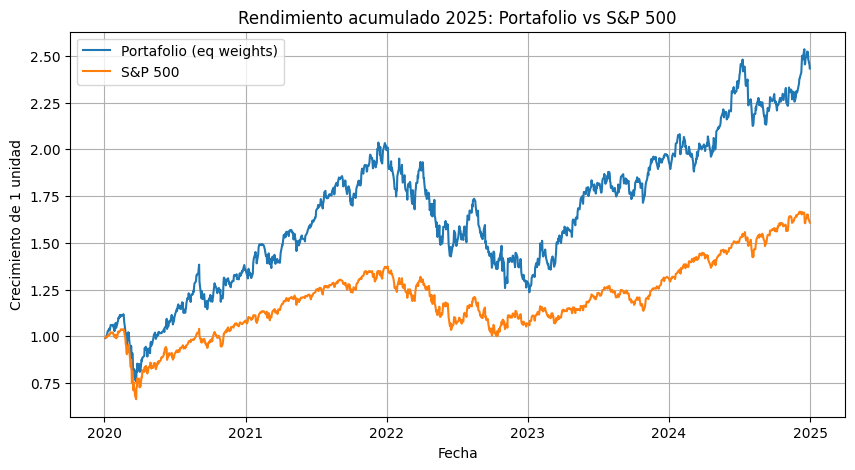

In [ ]:
### 6.- Grafico portafolio vs benchmark (este año)

from datetime import date

current_year = date.today().year

plt.figure(figsize=(10,5))
plt.plot(cum_port.index,  cum_port,  label="Portafolio (eq weights)")
plt.plot(cum_bench.index, cum_bench, label="S&P 500")
plt.legend()
plt.title(f"Rendimiento acumulado {current_year}: Portafolio vs S&P 500")
plt.xlabel("Fecha")
plt.ylabel("Crecimiento de 1 unidad")
plt.grid(True)
plt.show()


In [ ]:
### 7.- Optimizar Sharpe solo para este año

def negative_sharpe(weights, returns, rf_annual=RISK_FREE_ANNUAL):
    return -portfolio_performance(weights, returns, rf_annual)["sharpe"]

def optimize_max_sharpe(returns):
    n = returns.shape[1]
    init_w = np.ones(n) / n
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

    result = minimize(negative_sharpe,
                      init_w,
                      args=(returns,),
                      method="SLSQP",
                      bounds=bounds,
                      constraints=constraints)
    return result.x

opt_weights = optimize_max_sharpe(returns)
opt_weights, dict(zip(TICKERS, np.round(opt_weights, 3)))


(array([0.79737525, 0.20262475, 0.        ]),
 {'GOOG': np.float64(0.797),
  'AAPL': np.float64(0.203),
  'MSFT': np.float64(0.0)})

In [ ]:
### 8.- RESUMEN DEL PORTAFOLIO

opt_summary, opt_cum_port, _ = summarize_portfolio(opt_weights, returns, benchmark_return)
opt_summary


{'Annual Return': np.float64(0.2392577567127028),
 'Annual Volatility': np.float64(0.2993480993077287),
 'Sharpe': np.float64(0.041931312955877896),
 'Max Drawdown': -0.3688191429857334,
 'Daily VaR 95%': np.float64(-0.030411250924964273)}

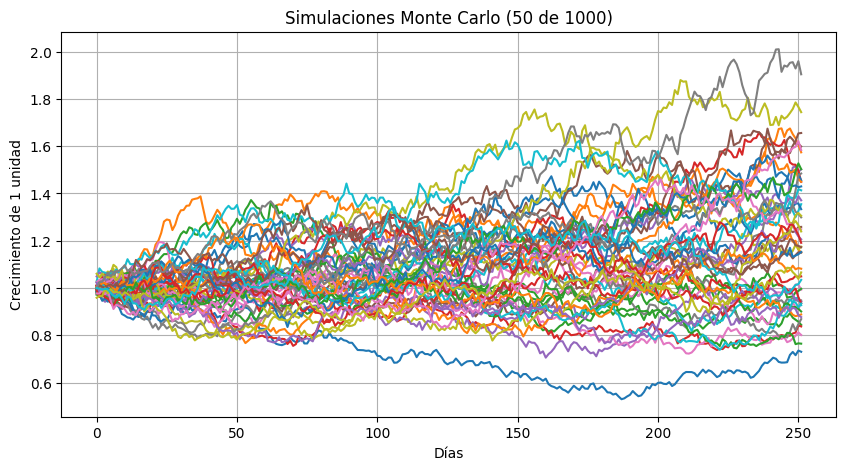

array([0.7609589 , 1.17979354, 1.84598647])

In [ ]:
### 9.- Usaré los pesos iguales (equal_weights), pero si quieres puedes cambiar a opt_weights

### Vamos a usar los retornos de este año (returns) para estimar media y covarianza, y simular muchos escenarios futuros para el portafolio.

import numpy as np
import matplotlib.pyplot as plt

def monte_carlo_portfolio(returns, weights, days=252, sims=1000):
    weights = np.array(weights)

    # medias y covarianza diarias de los activos
    mu  = returns.mean().values
    cov = returns.cov().values

    # simulamos retornos diarios multivariados correlacionados
    rand_matrix = np.random.multivariate_normal(mu, cov, size=(days, sims))

    # convertimos a retornos del portafolio (combinación lineal por los pesos)
    port_returns = rand_matrix @ weights

    # generamos trayectoria del valor del portafolio (empezando en 1)
    paths = (1 + port_returns).cumprod(axis=0)
    return paths

# simulamos 1 año (252 días) con 1000 escenarios
paths = monte_carlo_portfolio(returns, equal_weights, days=252, sims=1000)

# Graficamos unas cuantas trayectorias
plt.figure(figsize=(10,5))
plt.plot(paths[:, :50])  # solo las primeras 50 para que se vea legible
plt.title("Simulaciones Monte Carlo (50 de 1000)")
plt.xlabel("Días")
plt.ylabel("Crecimiento de 1 unidad")
plt.grid(True)
plt.show()

# Distribución del valor final al cabo de 1 año
final_values = paths[-1, :]
np.percentile(final_values, [5, 50, 95])

### El np.percentile(...) te da algo así como:

# 5% → escenario malo

# 50% → escenario mediano

# 95% → escenario muy bueno
